In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from nodepy import rk
from IPython.display import clear_output
import sys
from nodepy import rk, stability_function
from numpy.linalg import eig
import random
from scipy.fft import fft, ifft, rfft


rk4 = rk.loadRKM('RK44').__num__()
ssp3 = rk.loadRKM('SSP33').__num__()
ssp2 = rk.loadRKM('SSP22').__num__()
bs5 = rk.loadRKM('BS5').__num__()

A22= np.array([[0,0],[0.5,0]])
b22= np.array([0,1])
rk2= rk.ExplicitRungeKuttaMethod(A22,b22)

A31= np.array([[0,0,0], [2/3,0,0], [1/3,1/3,0]])
b31= np.array([1/4, 0, 3/4])
rk31=  rk.ExplicitRungeKuttaMethod(A31,b31)
rk31.bhat= np.array([1/4, 3/8, 3/8])

A32= np.array([[0,0,0], [0.5,0,0], [-1, 2,0]])
b32= np.array([1/6,2/3, 1/6])
rk32=  rk.ExplicitRungeKuttaMethod(A32,b32)


#base_methods= [ssp2, ssp3, rk4, bs5]
base_methods= [rk2, rk31, rk4, bs5]

#base_method_labels= ["SSPRK(2,2)","SSPRK(3,3)", "RK(4,4)", "BSRK(8,5)"]
base_method_labels= ["RK(2,2)","RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

types= ["RK", "RRK", "RFRK"]

k= np.zeros((4,8))
k[0,:]= [1,-1,0,0,0,0,0,0]
k[1,:]= [2,-1,-1,0,0,0,0,0]
k[2,:]= [1,2,-2,-1,0,0,0,0]
k[3,:]= [2,-1,-1,0,0,0,0,0]

print(ssp2.b)
## ssp2:



[0.5 0.5]


In [20]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]

In [21]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [22]:
# Required functions for Euler's equation
# Definition of the RHS Function:
def f(u):
    # left and right values
    ul = np.zeros(np.size(u)+1)
    ul[1:] = u; ul[0] = u[-1]
    ur = np.zeros_like(ul)
    ur[:-1] = u; ur[-1] = u[0]
    # compute numerical fluxes
    fluxes = (ul * ul + ul * ur + ur * ur) /6 - mu*(ur-ul)
    # compute flux differences
    fluxdiff = -(fluxes[1:] - fluxes[:-1]) / dx
    return fluxdiff



def G_1(u):
    
    return 0.5*np.dot(u,u)

def dG_1(u):
    return u






def rgam(gamma,u,inc1,E1_old, est):
    gamma1 = gamma
    uprop = u + gamma1*inc1 
    E1 = G_1(uprop)

    return E1-E1_old - (gamma1+1)*est

def rgam_RF(eps,dt, u_tilde, search1, E1_old, est):
    
    
    uprop = u_tilde + dt* eps* search1 
    E1 = G_1(uprop)

    return E1-E1_old - est


def proj_distance(k_0, s, F, dt, u_tilde, E1_old, est):

    no_inv = 1; eps0 = 0.1
    
    
    k_01= k_0.copy()
    

    search_01= sum([k_01[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_01[i]*F[i,:] for i in range(s)]))
    #search_02= sum([k_02[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_02[i]*F[i,:] for i in range(s)]))

    eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search_01,E1_old, est),full_output=True)
    #print('mesg: ', mesg)
 

    distance= np.linalg.norm(dt*eps* search_01 )
    #print('distance_opt: ', distance)
    #print('k_1 optimized: ', k_01)
    #print('k_2 optimized: ', k_02)
    return distance

    

def Angle_between(v1, v2):
    
    V1= v1/np.linalg.norm(v1)


    
    V2= v2/np.linalg.norm(v2)

    return (180/np.pi)* np.arccos(np.dot(V1, V2))



In [23]:
def project_direction(u, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))




    for i in range(s):
        normal = np.copy(F[i , :])
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-7:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    print('size of the matrix Normals: ',Normals[:,1].size)
    
 
    
    u_projected= np.zeros(n)
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        u_projected += np.dot(u, Normals[i, :])* Normals[i, :]

    #print('optimized deg:', (180/np.pi)* np.arccos(np.dot(u, u_projected)/ (np.linalg.norm(u)* np.linalg.norm(u_projected))))

    return u_projected, Normals
    

In [24]:
m=128
h= 2*np.pi/m


D= np.zeros((m,m))
for i in range(m):
    for j in range(m):
        x_i= i*h
        x_j=j*h

        if i==j:
            D[i,j]=0
        else:
            D[i,j]= 0.5* (-1)**(i+j) * ( np.cos(0.5*(x_i-x_j)) / np.sin(0.5*(x_i-x_j)) )

w, v = eig(D)
#print('Eig values: ',w)



def f(q):
    return -np.dot(D,q)

Definition of the general integration function

# Base RK

In [25]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    steps = 0

    n=0 #test
    
    #while t < T and not np.isclose(t, T):
    while t < T and not n >= 1 and not np.isclose(t, T):
        #clear_output(wait=True)
        n+=1 #test
        
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            #print('fi.yi= ',np.dot(f(y[i,:]), y[i,:]))
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        #print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu, F, y

# Quasi-Orthogonal Projection

In [26]:
def compute_sol_QO(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Eps1 = np.array([]); 
    Eps1 = np.append(Eps1, 0)
    
    no_inv = 1; eps0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    #while t < T and not np.isclose(t, T):
    while t < T and not n >= 1 and not np.isclose(t, T):

        n+=1 #test
        #clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 
        print('Energy change with base RK: ',G_1(wr_unew) - E1_old)


        search , Normals= project_direction (dG_1(wr_unew), F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search) < 1.e-5:
            print('Search close to zero')

        search= search /np.linalg.norm(search)

      
        
            


        
        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, wr_unew,search,E1_old, est),full_output=True)
        
        print('eps: ', eps)


       

        
        

        
    
        

        
        
        unew =   wr_unew + dt*eps*search  ; t+=dt
        inc_hat= inc1 + dt*eps*search
        
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Eps1 = np.append(Eps1, eps);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ;

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search))

        proj_angle= np.append(proj_angle, Angle_between(eps*search  , dG_1(wr_unew)) )
        
        print("Method = Orthogonal %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, F, Normals, Eps1 , dG_1(wr_unew), search, inc_hat, y

In [27]:
def modified_plot_stability_region(p,q, linestyle='-',N=200,color='r',filled=True,bounds=None,
                          plotroots=False,alpha=1.,scalefac=1.,fignum=None): 
    # from https://github.com/ketch/nodepy/blob/master/nodepy/stability_function.py
    r"""
        Plot the region of absolute stability of a rational function; i.e. the set

        `\{ z \in C : |\phi (z)|\le 1 \}`

        Unless specified explicitly, the plot bounds are determined automatically, attempting to
        include the entire region.  A check is performed beforehand for
        methods with unbounded stability regions.
        Note that this function is not responsible for actually drawing the
        figure to the screen (or saving it to file).

        **Inputs**:
            - p, q  -- Numerator and denominator of the stability function
            - N       -- Number of gridpoints to use in each direction
            - color   -- color to use for this plot
            - filled  -- if true, stability region is filled in (solid); otherwise it is outlined
            - plotroots -- if True, plot the roots and poles of the function
            - alpha -- transparency of contour plot
            - scalefac -- factor by which to scale region (often used to normalize for stage number)
            - fignum -- number of existing figure to use for plot

    """
    import matplotlib.pyplot as plt

    # Convert coefficients to floats for speed
    if p.coeffs.dtype=='object':
        p = np.poly1d([float(c) for c in p.coeffs])
    if q.coeffs.dtype=='object':
        q = np.poly1d([float(c) for c in q.coeffs])

    if bounds is None:
        from nodepy.utils import find_plot_bounds
        # Check if the stability region is bounded or not
        m,n = p.order,q.order
        if (m < n) or ((m == n) and (abs(p[m])<abs(q[n]))):
            print('The stability region is unbounded')
            if m > 0:
                bounds = (-10*m,m,-5*m,5*m)
            else:
                bounds = (-10,1,-5,5)
        else:
            stable = lambda z : np.abs(p(z)/q(z))<=1.0
            bounds = find_plot_bounds(stable,guess=(-10,1,-5,5))
            if np.min(np.abs(np.array(bounds)))<1.e-14:
                print('No stable region found; is this method zero-stable?')

        if (m == n) and (abs(p[m])==abs(q[n])):
            print('The stability region may be unbounded')

    # Evaluate the stability function over a grid
    x=np.linspace(bounds[0],bounds[1],N)
    y=np.linspace(bounds[2],bounds[3],N)
    X=np.tile(x,(N,1))
    Y=np.tile(y[:,np.newaxis],(1,N))
    Z=X+Y*1j
    R=np.abs(p(Z*scalefac)/q(Z*scalefac))

    # Plot
    h = plt.figure(fignum)
    if filled:
        plt.contourf(X,Y,R,[0,1],colors=color,alpha=alpha)
    else:
        plt.contour(X,Y,R,[0,1],colors=color,alpha=alpha,linewidths=4, linestyles=linestyle)

    plt.axis('Image')
    return h


In [28]:
plt.rc("font", size=22)

def QO_stability_polynomial(base,k, eps):
    b= base.b
    A= base.A

    s= len(b)
    b_hat= np.zeros(s)

    print('eps: ',eps)
    print('k:',k)
    b_hat= b + k*eps
    
        
    QO_scheme= rk.ExplicitRungeKuttaMethod(A,b_hat)

    P, Q = QO_scheme.stability_function()

    
    return P


def plot_stability_regions(base, k,eps_s, alph, linestyles):
    fig=plt.figure(figsize=(12,12))
    q = np.poly1d([1])
    i=0
    for eps in eps_s:
        p = QO_stability_polynomial(base, k, eps)
      
   
        modified_plot_stability_region(p,q,linestyles[i],filled=False,color='k',bounds=[-4,1,-4,4], fignum=fig.number, alpha=alph[i])
                                                
        i+= 1
    p = QO_stability_polynomial(base, k, 0)
    modified_plot_stability_region(p,q,linestyles[0],filled=True,color='r',alpha=1,bounds=[-3,1,-4,4], fignum=fig.number)


# Example case 1

In [29]:
rkm= rk4

#Stability limit interval of RK(4,4)
stab_limit= rkm.imaginary_stability_interval()
#print(stab_limit)



dt_max= stab_limit/(m/2-1)
mus= [0.2, 0.5, 0.9, 0.99, 1.02]


m=128
h= 2*np.pi/m


x= np.arange(m)*h -np.pi  # [-pi , .., pi]
#print('x',x)



q0_smooth= np.exp(-30*x**2)


q_hat_0= [np.exp(1j* random.random()) for i in range(m)]
#q_hat_0= [np.exp(1j) for i in range(m)]
#print(q_hat_0)
idf_q_hat= ifft(q_hat_0)
#print('ifft_u_hat_0: ',abs(idf_u_hat))
q0_noise= np.real(idf_q_hat)


mu= 0.3

t_final=1
dt= mu* dt_max



# Quasi-Orthogonal

est:  1.9937682015032054e-17
Energy change with base RK:  -7.789384248724218e-08
size of the matrix Normals:  5
eps:  [3.92111286e-06]
Method = Orthogonal rk: At step number = 1 (time = 0.01), integer flag = 5 and E1-E1_old = 0.000000 

tt:  [0.        0.0134687]
Energy_change:  [0.]
k_QQ:  [-79.98185714  -2.23425338 164.4443968  -82.21915446]
||k_QO||:  40204.03835813865
||search_QO||:  0.9999999999999998
eps_QO: 3.921112855783686e-06
b_hat:  [0.16635305 0.33332457 0.33397814 0.16634428]
eps:  0.0003921112855783686
k: [-79.98185714  -2.23425338 164.4443968  -82.21915446]
eps:  3.921112855783686e-06
k: [-79.98185714  -2.23425338 164.4443968  -82.21915446]
eps:  -0.0003921112855783686
k: [-79.98185714  -2.23425338 164.4443968  -82.21915446]
eps:  0
k: [-79.98185714  -2.23425338 164.4443968  -82.21915446]


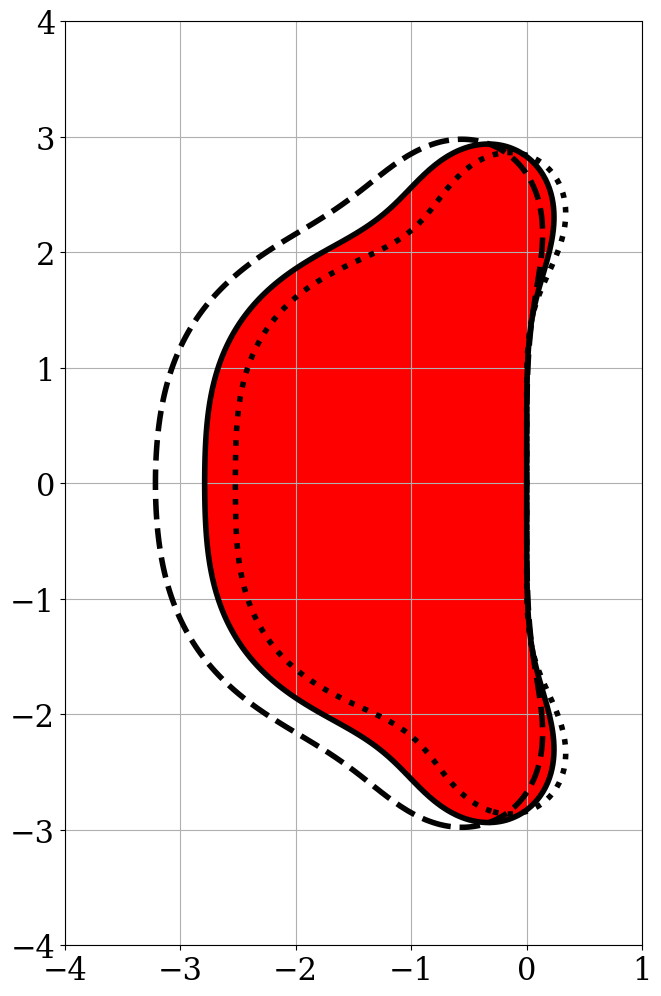

In [30]:

rkm= rk4
b= rkm.b
s= b.size

q0= q0_smooth

tt, qq_QO,F_QO, Normals,  Eps1_QO , dG, search_QO, inc_hat, y_QO= compute_sol_QO("rk",rkm, dt, f, t_final, q0,t0=0)



print('tt: ', tt)
E= np.zeros_like(tt)
for i in range(len(tt)):
    E[i]= np.dot(qq_QO[i, :], qq_QO[i, :])
print('Energy_change: ',E[1:]- E[0])


S= np.zeros((s,s)) # F[s,n]= S[s,s] * Normals[s,n]

for i in range(s):
    for j in range(s):
        S[i,j]= np.dot(F_QO[i, :], Normals[j+1, :])

# Normals[s,n]= S^{-1}[s,s] F[s,n]

L= np.zeros(s) # search[1,n]= L[1,s] * Normals[s,n]
for i in range(s):
    L[i]= np.dot(search_QO, Normals[i+1, :])

k_QO = np.matmul(L, np.linalg.inv(S))

print('k_QQ: ', k_QO)
print('||k_QO||: ', np.dot(k_QO, k_QO))



print('||search_QO||: ', np.dot(search_QO, search_QO))


eps_QO= Eps1_QO[-1]
print('eps_QO:',eps_QO)

print('b_hat: ', rkm.b + eps_QO*k_QO)


eps_s_QO= [  100*eps_QO, eps_QO,  -100*eps_QO]


alph= [0.99,0.99, 0.99]
linestyles = ['--','-', ':']



plot_stability_regions(rkm, k_QO,eps_s_QO, alph, linestyles)
#plt.yticks([-2.785,0, 2.785])
plt.grid()

plt.savefig("Figures/Stability_region.png")

plt.show()
#plt.legend(['RK'])

In [15]:
# Just for making the legend

#plt.plot([0,1], [0,0],'k', lw=4, label='$\lambda= \lambda_n $')
#plt.plot([0,1], [0,0],  'k--', lw=4, label='$\lambda= 100  \lambda_n$')
#plt.plot([0,1], [0,0],  'k:', lw=4,  label='$\lambda= -100  \lambda_n$')

#ax = plt.gca()
#plt.figure()
#handles, labels = ax.get_legend_handles_labels()
#plt.figlegend(handles, labels, loc="center", ncol=3)
#plt.savefig("./Figures/Stability_region_legend.png",bbox_inches="tight")


#plt.show()  


# White noise initial data

In [31]:
q0= q0_noise


rkm= rk4
b= rkm.b
s= b.size

tt, qq_QO,F_QO, Normals,  Eps1_QO , dG, search_QO, inc_hat, y_QO= compute_sol_QO("rk",rkm, dt, f, t_final, q0,t0=0)




S= np.zeros((s,s)) # F[s,n]= S[s,s] * Normals[s,n]

for i in range(s):
    for j in range(s):
        S[i,j]= np.dot(F_QO[i, :], Normals[j+1, :])

# Normals[s,n]= S^{-1}[s,s] F[s,n]

L= np.zeros(s) # search[1,n]= L[1,s] * Normals[s,n]
for i in range(s):
    L[i]= np.dot(search_QO, Normals[i+1, :])

k_QO = np.matmul(L, np.linalg.inv(S))

print('k_QQ: ', k_QO)
print('||k_QO||: ', np.dot(k_QO, k_QO))


eps_QO= Eps1_QO[-1]
print('eps_QO:',eps_QO)

#-------------------------------------------------------------------


est:  -1.70716402253712e-17
Energy change with base RK:  -0.0002541382648473256
size of the matrix Normals:  5
eps:  [0.02635257]
Method = Orthogonal rk: At step number = 1 (time = 0.01), integer flag = 1 and E1-E1_old = 0.000000 

k_QQ:  [-0.35286352 -0.23469571  1.20020558 -0.59383101]
||k_QO||:  1.9727234506397837
eps_QO: 0.02635256639005092


In [32]:
def stability_val(eig, rk, k, eps):
    
    b_hat= rk.b + k*eps
    R= 1 + eig* np.dot(b_hat,  np.matmul( np.linalg.inv(  np.identity(b_hat.size)-eig*rk.A ) , np.ones(b_hat.size) )   )
    
    return R

[1.         1.00000062 1.00000248 1.00000557 1.00000989 1.00001541
 1.00002212 1.00002999 1.00003899 1.00004909 1.00006024 1.00007242
 1.00008555 1.0000996  1.00011449 1.00013016 1.00014653 1.00016353
 1.00018107 1.00019905 1.00021737 1.00023592 1.00025458 1.00027323
 1.00029172 1.00030991 1.00032765 1.00034476 1.00036108 1.00037641
 1.00039055 1.00040329 1.0004144  1.00042365 1.00043078 1.00043553
 1.00043761 1.00043674 1.00043259 1.00042484 1.00041314 1.00039713
 1.00037643 1.00035065 1.00031936 1.00028212 1.00023849 1.00018797
 1.00013008 1.0000643  0.99999008 0.99990685 0.99981404 0.99971103
 0.99959718 0.99947185 0.99933434 0.99918396 0.99901996 0.99884159
 0.99864806 0.99843857 0.99821227 0.9979683  0.99770577]


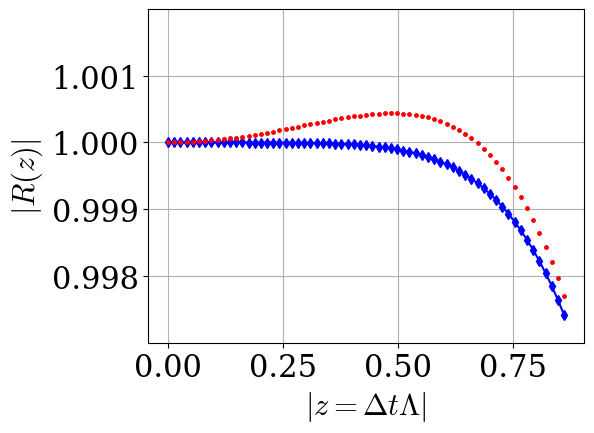

<Figure size 640x480 with 0 Axes>

In [33]:
eig= np.arange(0, 65, 1)*1j
#print(eig)

stab_mag_RK= np.zeros(65)
stab_mag_QO= np.zeros(65)
stab_mag_D= np.zeros(65)
stab_mag_R= np.zeros(65)


for i in range(65):
    stab_mag_RK[i]= np.abs(stability_val(i*1j* dt, rk4, k_QO, 0))
    stab_mag_QO[i]= np.abs(stability_val(i*1j* dt, rk4, k_QO, eps_QO))

    
print(stab_mag_QO)

lambd= 64

fig = plt.figure(1)

plt.plot(np.arange(65)*dt, stab_mag_RK, 'd-b',markersize=5, label= 'Base RK')
plt.plot(np.arange(65)*dt, stab_mag_QO, 'r.', markersize=5, label= 'Quasi-Orthogonal')



plt.ylim(0.997, 1.002)

plt.xlabel('$|z =\Delta t \Lambda |$'); plt.ylabel('$|R(z)|$')

plt.yticks([0.9980, .9990,1, 1.001])
plt.grid()

fig.tight_layout()


plt.savefig("Figures/Stability_values.png")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=2)
plt.savefig("./Figures/Stability_values_legend.png",bbox_inches="tight")


plt.show()  


plt.show()